# 1.匯入套件

In [1]:
#常用
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # 另一個繪圖-樣式套件
import warnings
warnings.filterwarnings('ignore')

#統計
import scipy.stats as st

#機器學習
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression

#系統操作、解壓縮檔案
import os
from zipfile import ZipFile

In [69]:
###資料匯入
class DataImport:
    def __init__(self):
        self.data_dir = os.getcwd()
    
    #資料夾路徑
    def set_dir(self, data_path):
        self.data_dir = os.path.join(self.data_dir, data_path)
    
    #壓縮檔名 
    def read_zip(self, filename):
        self.file_path = os.path.join(self.data_dir, filename)
        print('Path of read in data: %s' % (self.file_path))
        myzip=ZipFile(self.file_path)
        for i in myzip.filelist:
            print(i.filename)
        myzip.close()
    
    #讀取壓縮檔內的資料
    def read_zip_data(self, dataname):
        myzip=ZipFile(self.file_path)
        f=myzip.open(dataname)
        df=pd.read_csv(f)
        f.close()
        myzip.close()
        return df


### EDA
#ref : https://www.kaggle.com/dgawlik/house-prices-eda
class EDA:
    
    def __init__(self, train, test):
        self.train = train
        self.test = test
        self.train_cols = train.columns
        self.test_cols = test.columns
    
    
    def get_features_type(self):
        self.numeric_features=[]
        self.categorical_features = []
        for dtype, feature in zip(self.train.dtypes, self.train.columns):
            if dtype == 'object':
                self.categorical_features.append(feature)
            else :
                self.numeric_features.append(feature)
    
    
    def categorical_check(self):    
        categorical_type = self.train[self.categorical_features].apply(pd.Series.nunique, axis = 0).reset_index() 
        categorical_type.columns = ["Column", "Unique Count"]
        display(categorical_type.head(len(self.categorical_features))) 
    
    def na_check(self):
        data_na = (self.train.isnull().sum() / len(self.train)) * 100
        data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio' :data_na})
        display(missing_data.head(data_na.shape[0]))
    
    def overview(self):
        print('Train data :{}'.format(self.train.shape))
        print('Test data :{}'.format(self.test.shape))
        print('\n')
        print(f'{len(self.numeric_features)} Numeric_Features : {self.numeric_features}\n')
        print(f'{len(self.categorical_features)} Categorical Features : {self.categorical_features}\n')
        print('\n')
        self.categorical_check()
        self.na_check()
        
    def drop_feature(self, name):
        try:
            self.numeric_features.remove(name)
            print('Remove finish')
        except:
            pass
        try:
            self.categorical_features.remove(name)
            print('Remove finish')
        except:
            pass
        
    def set_target(self, name):
        self.target = name
        try:
            self.numeric_features.remove(name)
            print('Set finish')
        except:
            pass
        try:
            self.categorical_features.remove(name)
            print('Set finish')
        except:
            pass
    
    def y_distribution(self, log1p=False):
        if log1p:
            train_y = np.log1p(self.train[self.target])
        else:
            train_y = self.train[self.target]
        plt.figure(1,figsize=(8, 6))
        plt.title('Y')
        sns.distplot(train_y, 
                     kde=False, 
                     fit=st.norm)

        plt.figure(2,figsize=(8, 6))
        res = st.probplot(train_y,plot=plt)
        plt.show()
        
    def numeric_plot(self):
        for c in self.numeric_features:
            num_plot = sns.jointplot(x=c, y=self.target, data=self.train,kind='scatter',color='#0066CC')
            num_plot.ax_joint.set_ylabel(self.target,rotation=0)
            plt.show()
    
    def categorical_plot(self):
        for c in self.categorical_features:
            sns.boxplot(x = c, y = self.target, data=self.train,color='#0066CC')
            plt.xticks(rotation=90)
            plt.show()
    
    def anova(self):
        frame = self.train.copy()
        anv = pd.DataFrame()
        anv['feature'] = self.numeric_features
        pvals = []
        for c in self.numeric_features:
            samples = []
            for cls in frame[c].unique():
                s = frame[frame[c] == cls][self.target].values
                samples.append(s)
            pval = st.f_oneway(*samples)[1]
            pvals.append(pval)
        anv['pval'] = pvals
        anv = anv.sort_values('pval')
        anv['disparity'] = np.log(1./anv['pval'].values)
        self.anv = anv
        plt.figure(1,figsize=(8, 6))
        sns.barplot(data=anv, x='feature', y='disparity')
        x=plt.xticks(rotation=90)
        plt.show()
        
    def spearman(self):
        frame = self.train.copy()
        spr = pd.DataFrame()
        spr['feature'] = self.numeric_features
        spr['spearman'] = [frame[c].corr(frame[self.target], 'spearman') for c in self.numeric_features]
        spr = spr.sort_values('spearman')
        self.spr = spr
        plt.figure(figsize=(6, 0.25*len(self.numeric_features)))
        sns.barplot(data=spr, y='feature', x='spearman', orient='h')
        plt.show()
        
    def correlation_matrix(self):
        correlations = self.train.loc[:,self.numeric_features].corr()
        plt.figure(1,figsize=(8, 6))
        sns.heatmap(correlations,
                    cmap = 'seismic',
        #             annot=True,
                    fmt ='0.1g',
                    center = 0)
        plt.show()

        
class Outlier:
    def __init__(self, train, test):
        self.train = train
        self.test = test
        self.train_cols = train.columns
        self.test_cols = test.columns
    
    def set_target(self, name, func=False):
        self.target_name = name
        if func:
            self.target = pd.Series(map(func,self.train[name]))
        else:
            self.target = self.train[name]
    
    def target_distribution(self):
        plt.figure(1,figsize=(8, 6))
        plt.title(self.target_name)
        sns.distplot(self.target, 
                     kde=False, 
                     fit=st.norm)

        plt.figure(2,figsize=(8, 6))
        res = st.probplot(self.target,plot=plt)
        plt.show()
    
    def summarize(self):
        print('{} Skewness is {:.2f}'.format(self.target_name, self.target.skew()))
        print('{} Kurtosis is {:.2f}'.format(self.target_name, self.target.kurt()))
        self.target_distribution()
    
    def boxplot_calculate(self):
        sns.boxplot(outlier.target)
        plt.show()
        self.q1 = np.quantile(self.target, 0.25)
        self.q2 = np.quantile(self.target, 0.5)
        self.q3 = np.quantile(self.target, 0.75)
        self.iqr = self.q3-self.q1
        self.upper_bound = self.q3+(1.5*self.iqr)
        self.lower_bound = self.q1-(1.5*self.iqr)
        self.box_outlier_index = self.target[(self.target<self.lower_bound)|(self.target>self.upper_bound)].index
        print('number of outlier(box) : {}'.format(len(self.box_outlier_index)))
        
    def standard_calculate(self):
        z_scaler = StandardScaler()
        self.target_z = z_scaler.fit_transform(self.target.values.reshape(-1, 1))
        self.target_z = pd.Series(self.target_z.reshape(-1, ))
        self.z_outlier_index = self.target_z[(self.target_z<-3)|(self.target_z>3)].index
        print('number of outlier(z) : {}'.format(len(self.z_outlier_index)))

class Feature_Engineering:
    def __init__(self, train, test):
        self.train = train
        self.test = test
        self.train_cols = train.columns
        self.test_cols = test.columns
    
    def get_features_type(self):
        self.numeric_features=[]
        self.categorical_features = []
        for dtype, feature in zip(self.train.dtypes, self.train.columns):
            if dtype == 'object':
                self.categorical_features.append(feature)
            else :
                self.numeric_features.append(feature)
                
    def drop_feature(self, name):
        try:
            self.numeric_features.remove(name)
            print('Remove finish')
        except:
            pass
        try:
            self.categorical_features.remove(name)
            print('Remove finish')
        except:
            pass

    def set_target(self, name):
        self.target = name
        try:
            self.numeric_features.remove(name)
            print('Set finish')
        except:
            pass
        try:
            self.categorical_features.remove(name)
            print('Set finish')
        except:
            pass
    
    def drop_outlier(self, index):
        self.train = self.train.drop(index)
        print('Drop {} rows'.format(len(index)))
    
    def split_train_yX(self):
        self.train_y = self.train[self.target]
        self.train_X = self.train[self.numeric_features + self.categorical_features]
        
    def numeric_missing_value(self, cols, how='fillna_median', group_by=False):
        if how =='fillna_median':
            for c in cols:
                self.train_X[c] = self.train_X[c].fillna(self.train_X[c].median())
        elif how =='fillna_0':
            for c in cols:
                self.train_X[c] = self.train_X[c].fillna(0)
    
    def numeric_discretize(self):
        

# 2. 匯入資料

In [3]:
DTImport = DataImport()
DTImport.set_dir(data_path = './data/')
DTImport.read_zip(filename = 'house-prices.zip')
train = DTImport.read_zip_data(dataname = 'train.csv')
test = DTImport.read_zip_data(dataname = 'test.csv')

Path of read in data: C:\Users\RT009223\Github\Projects\SideProject\03_Kaggle_House_Prices\./data/house-prices.zip
data_description.txt
sample_submission.csv
test.csv
train.csv


# 3. EDA

In [4]:
eda = EDA(train=train, test=test)

Train data :(1460, 81)
Test data :(1459, 80)


38 Number_Features : ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']

43 Object Features : ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'El

,Column,Unique Count
0,MSZoning,5
1,Street,2
2,Alley,2
3,LotShape,4
4,LandContour,4
5,Utilities,2
6,LotConfig,5
7,LandSlope,3
8,Neighborhood,25
9,Condition1,9


,Missing Ratio
PoolQC,99.520548
MiscFeature,96.301370
Alley,93.767123
Fence,80.753425
FireplaceQu,47.260274
LotFrontage,17.739726
GarageYrBlt,5.547945
GarageType,5.547945
GarageFinish,5.547945
GarageQual,5.547945


Remove finish
Set finish


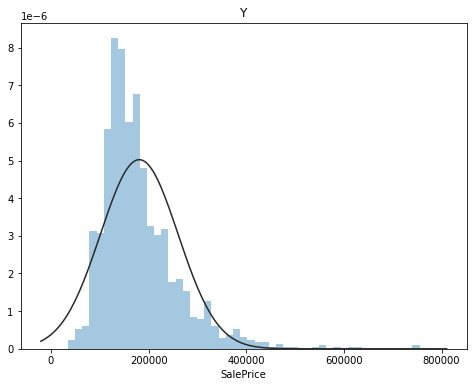

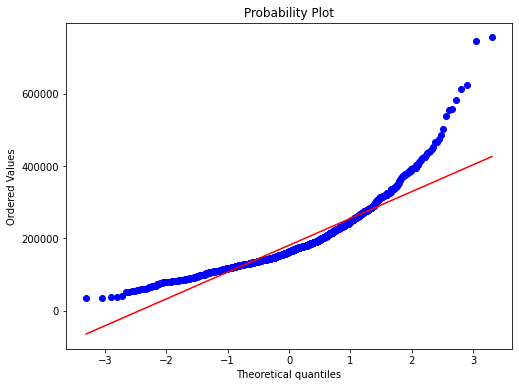

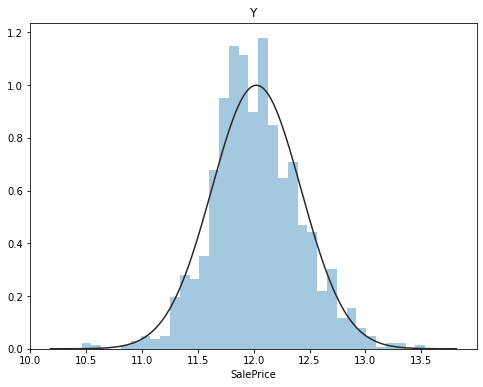

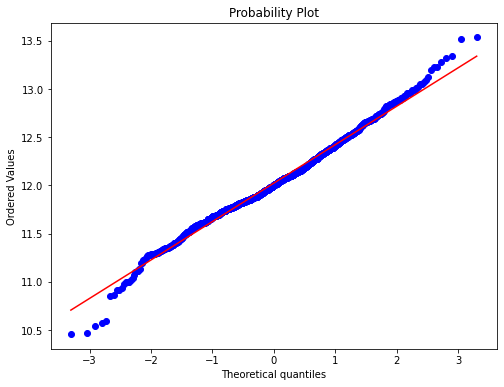

In [5]:
eda.get_features_type()
eda.overview()
eda.drop_feature(name='Id')
eda.set_target('SalePrice')
eda.y_distribution()
eda.y_distribution(log1p=True)

# eda.numeric_plot()
# eda.categorical_plot()

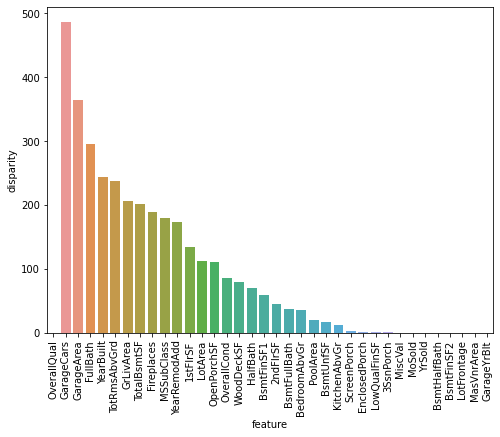

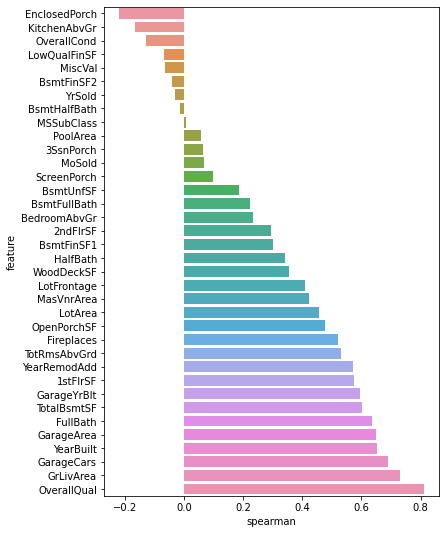

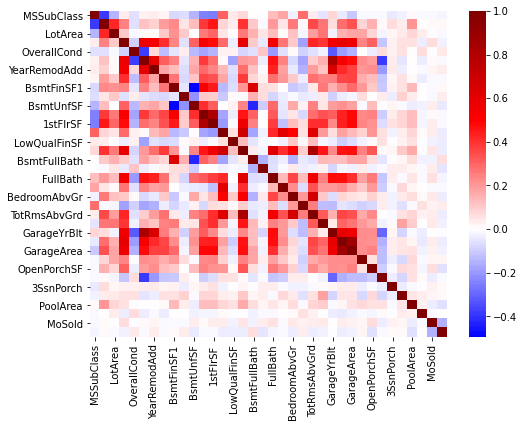

In [6]:
eda.anova()
eda.spearman()
eda.correlation_matrix()

In [53]:
outlier = Outlier(train= train, test= test)

SalePrice Skewness is 0.12
SalePrice Kurtosis is 0.81


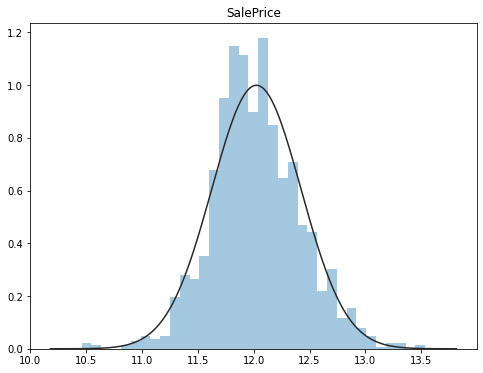

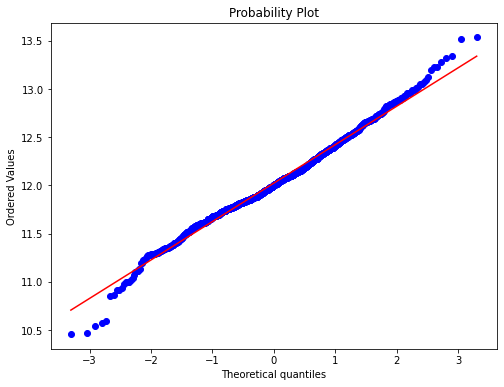

In [54]:
outlier.set_target(name='SalePrice' 
                   ,func=np.log1p
                  )
outlier.summarize()

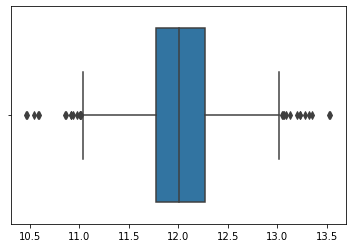

number of outlier(box) : 28
number of outlier(z) : 12


In [60]:
outlier.boxplot_calculate()
outlier.standard_calculate()

In [ ]:
outlier.z_outlier_index

In [65]:
outlier.train.drop(outlier.z_outlier_index)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
